In [1]:
import sys
print(sys.executable)



/home/kote78/Proyectos/garmin-connect/.venv/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("data/processed/minute.parquet")
assert DATA.exists(), f"No existe {DATA}"

m = pd.read_parquet(DATA)
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp")

print("shape:", m.shape)
print("cols:", m.columns.tolist())
print("range:", m["timestamp"].min(), "->", m["timestamp"].max())
m.head()


shape: (123840, 8)
cols: ['timestamp', 'hr', 'stress', 'resp', 'bb', 'steps', 'kcal', 'sleep_flag']
range: 2025-09-01 00:00:00+02:00 -> 2026-01-08 23:59:00+01:00


,timestamp,hr,stress,resp,bb,steps,kcal,sleep_flag
0,2025-09-01 00:00:00+02:00,79.0,64.0,NaN,9.000000,14615.0,2670.0,0
1,2025-09-01 00:01:00+02:00,NaN,NaN,NaN,8.952381,14615.0,2670.0,0
2,2025-09-01 00:02:00+02:00,77.0,NaN,22.0,8.904762,14615.0,2670.0,0
3,2025-09-01 00:03:00+02:00,NaN,61.0,NaN,8.857143,14615.0,2670.0,0
4,2025-09-01 00:04:00+02:00,74.0,NaN,23.0,8.809524,14615.0,2670.0,0


In [3]:
import pandas as pd
import numpy as np

m = pd.read_parquet("data/processed/minute.parquet")
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")

for c in ["hr","stress","resp","bb","sleep_flag"]:
    m[c] = pd.to_numeric(m[c], errors="coerce")
m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

# rangos plausibles
m.loc[(m["hr"] < 30) | (m["hr"] > 220), "hr"] = np.nan
m.loc[(m["stress"] < 0) | (m["stress"] > 100), "stress"] = np.nan
m.loc[(m["bb"] < 0) | (m["bb"] > 100), "bb"] = np.nan
m.loc[(m["resp"] < 4) | (m["resp"] > 40), "resp"] = np.nan

x = m.resample("15min").agg({
    "hr":"mean",
    "stress":"mean",
    "resp":"mean",
    "bb":"last",
    "sleep_flag":"max",
})

# bb escalonada: ffill dentro de lo que haya; no inventa gaps grandes porque no existen filas en gaps
x["bb"] = x["bb"].ffill()

x.head()


,hr,stress,resp,bb,sleep_flag
timestamp,,,,,
2025-09-01 00:00:00+02:00,76.000000,64.400000,21.428571,8.333333,0.0
2025-09-01 00:15:00+02:00,71.571429,53.000000,19.571429,7.619048,0.0
2025-09-01 00:30:00+02:00,71.875000,52.800000,18.250000,6.904762,0.0
2025-09-01 00:45:00+02:00,75.285714,53.333333,15.500000,6.190476,0.0
2025-09-01 01:00:00+02:00,67.125000,36.000000,17.000000,5.476190,0.0


In [4]:
MIN_MAIN_SLEEP_MIN = 180  # 3h
x2 = x.copy()
x2["sleep_flag"] = x2["sleep_flag"].fillna(0).astype(int)

# segmentos consecutivos
x2["seg_id"] = (x2["sleep_flag"].ne(x2["sleep_flag"].shift())).cumsum()

segs = x2.groupby("seg_id").apply(lambda df: pd.Series({
    "state": int(df["sleep_flag"].iloc[0]),
    "start": df.index[0],
    "end": df.index[-1] + pd.Timedelta(minutes=15),
    "minutes": int(len(df) * 15),
})).reset_index(drop=True)

sleep_segs = segs[(segs["state"]==1) & (segs["minutes"]>=MIN_MAIN_SLEEP_MIN)].copy()
sleep_segs = sleep_segs.sort_values("start").reset_index(drop=True)

print("main sleep segments:", len(sleep_segs))
sleep_segs.head(10)


main sleep segments: 66


/tmp/ipykernel_35411/3663172923.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segs = x2.groupby("seg_id").apply(lambda df: pd.Series({


,state,start,end,minutes
0,1,2025-09-01 09:00:00+02:00,2025-09-01 13:00:00+02:00,240
1,1,2025-09-02 03:30:00+02:00,2025-09-02 07:00:00+02:00,210
2,1,2025-09-05 06:00:00+02:00,2025-09-05 09:30:00+02:00,210
3,1,2025-09-06 09:30:00+02:00,2025-09-06 15:30:00+02:00,360
4,1,2025-09-09 04:30:00+02:00,2025-09-09 09:15:00+02:00,285
5,1,2025-09-10 02:00:00+02:00,2025-09-10 07:45:00+02:00,345
6,1,2025-09-11 10:30:00+02:00,2025-09-11 14:00:00+02:00,210
7,1,2025-09-12 01:00:00+02:00,2025-09-12 09:15:00+02:00,495
8,1,2025-09-13 04:45:00+02:00,2025-09-13 09:15:00+02:00,270
9,1,2025-09-14 07:15:00+02:00,2025-09-14 14:15:00+02:00,420


In [5]:
def bb_first_awake_after(ts, window_hours=6):
    w = x2.loc[ts: ts + pd.Timedelta(hours=window_hours)]
    w = w[(w["sleep_flag"]==0) & w["bb"].notna()]
    return float(w["bb"].iloc[0]) if len(w) else np.nan

sleep_segs["wake_time"] = sleep_segs["end"]
sleep_segs["bb_first_awake"] = sleep_segs["wake_time"].apply(bb_first_awake_after)
sleep_segs["cycle_id"] = np.arange(1, len(sleep_segs)+1)

print("bb_first_awake non-null:", sleep_segs["bb_first_awake"].notna().sum(), "/", len(sleep_segs))
sleep_segs[["cycle_id","start","end","minutes","wake_time","bb_first_awake"]].head(15)


bb_first_awake non-null: 66 / 66


,cycle_id,start,end,minutes,wake_time,bb_first_awake
0,1,2025-09-01 09:00:00+02:00,2025-09-01 13:00:00+02:00,240,2025-09-01 13:00:00+02:00,47.292683
1,2,2025-09-02 03:30:00+02:00,2025-09-02 07:00:00+02:00,210,2025-09-02 07:00:00+02:00,43.666667
2,3,2025-09-05 06:00:00+02:00,2025-09-05 09:30:00+02:00,210,2025-09-05 09:30:00+02:00,55.904762
3,4,2025-09-06 09:30:00+02:00,2025-09-06 15:30:00+02:00,360,2025-09-06 15:30:00+02:00,60.820513
4,5,2025-09-09 04:30:00+02:00,2025-09-09 09:15:00+02:00,285,2025-09-09 09:15:00+02:00,64.358396
5,6,2025-09-10 02:00:00+02:00,2025-09-10 07:45:00+02:00,345,2025-09-10 07:45:00+02:00,31.037037
6,7,2025-09-11 10:30:00+02:00,2025-09-11 14:00:00+02:00,210,2025-09-11 14:00:00+02:00,5.000000
7,8,2025-09-12 01:00:00+02:00,2025-09-12 09:15:00+02:00,495,2025-09-12 09:15:00+02:00,90.777778
8,9,2025-09-13 04:45:00+02:00,2025-09-13 09:15:00+02:00,270,2025-09-13 09:15:00+02:00,43.968254
9,10,2025-09-14 07:15:00+02:00,2025-09-14 14:15:00+02:00,420,2025-09-14 14:15:00+02:00,68.439024


In [6]:
!pip -q install scikit-learn scipy


In [7]:
import pandas as pd
import numpy as np

m = pd.read_parquet("data/processed/minute.parquet")
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")

# Asegura 0/1 limpio
m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

# 1) Sueño total por día (minutos con sleep_flag=1)
sleep_by_day = m["sleep_flag"].resample("D").sum()

print("Días en dataset (resample D):", len(sleep_by_day))
print("Días con algo de sueño:", int((sleep_by_day > 0).sum()))
print("Días con >=180 min de sueño total:", int((sleep_by_day >= 180).sum()))
print("Días con 0 sueño:", int((sleep_by_day == 0).sum()))
print("Días con sueño pero <180 min:", int(((sleep_by_day > 0) & (sleep_by_day < 180)).sum()))

no_sleep_days = sleep_by_day[sleep_by_day == 0]
short_sleep_days = sleep_by_day[(sleep_by_day > 0) & (sleep_by_day < 180)]

display(no_sleep_days.head(20))
display(short_sleep_days.head(20))


Días en dataset (resample D): 130
Días con algo de sueño: 71
Días con >=180 min de sueño total: 64
Días con 0 sueño: 59
Días con sueño pero <180 min: 7


timestamp
2025-09-03 00:00:00+02:00    0
2025-09-04 00:00:00+02:00    0
2025-09-07 00:00:00+02:00    0
2025-09-08 00:00:00+02:00    0
2025-09-16 00:00:00+02:00    0
2025-09-17 00:00:00+02:00    0
2025-09-19 00:00:00+02:00    0
2025-09-20 00:00:00+02:00    0
2025-09-21 00:00:00+02:00    0
2025-09-22 00:00:00+02:00    0
2025-09-23 00:00:00+02:00    0
2025-09-24 00:00:00+02:00    0
2025-09-25 00:00:00+02:00    0
2025-09-26 00:00:00+02:00    0
2025-09-27 00:00:00+02:00    0
2025-09-28 00:00:00+02:00    0
2025-09-29 00:00:00+02:00    0
2025-09-30 00:00:00+02:00    0
2025-10-01 00:00:00+02:00    0
2025-10-02 00:00:00+02:00    0
Name: sleep_flag, dtype: int64

timestamp
2025-11-01 00:00:00+01:00    155
2025-11-25 00:00:00+01:00    153
2025-12-04 00:00:00+01:00    122
2025-12-08 00:00:00+01:00    163
2025-12-17 00:00:00+01:00      5
2025-12-19 00:00:00+01:00     76
2026-01-01 00:00:00+01:00     11
Name: sleep_flag, dtype: int64

In [8]:
import pandas as pd
import numpy as np

m = pd.read_parquet("data/processed/minute.parquet")
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")
m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

# días presentes de verdad (solo fechas que existen en el índice)
days_present = m.index.normalize()
sleep_present = m.groupby(days_present)["sleep_flag"].sum()

print("✅ Días PRESENTES (de verdad):", sleep_present.shape[0])
print("   (esto debería ser 86)")
print("✅ Días con algo de sueño:", int((sleep_present > 0).sum()))
print("✅ Días con 0 sueño (pero con datos):", int((sleep_present == 0).sum()))
print("✅ Días con sueño <180 min:", int(((sleep_present > 0) & (sleep_present < 180)).sum()))
print("✅ Días con sueño >=180 min:", int((sleep_present >= 180).sum()))

# ahora calcula cuántos días vacíos te estaba metiendo resample("D")
full_days = pd.date_range(days_present.min(), days_present.max(), freq="D", tz=m.index.tz)
missing_days = full_days.difference(pd.DatetimeIndex(days_present.unique()).tz_localize(m.index.tz))

print("\n📌 Días calendario en rango completo:", len(full_days))
print("📌 Días VACÍOS (gaps, no existen en tu dataset):", len(missing_days))

# muestra algunos días 0-sueño reales (con datos)
zero_real = sleep_present[sleep_present == 0]
print("\nEjemplos de días con datos pero sin sueño marcado:")
display(zero_real.head(15))


✅ Días PRESENTES (de verdad): 86
   (esto debería ser 86)
✅ Días con algo de sueño: 71
✅ Días con 0 sueño (pero con datos): 15
✅ Días con sueño <180 min: 7
✅ Días con sueño >=180 min: 64


TypeError: Already tz-aware, use tz_convert to convert.

In [9]:
import pandas as pd

m = pd.read_parquet("data/processed/minute.parquet")
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")
m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

days_present = m.index.normalize()
sleep_present = m.groupby(days_present)["sleep_flag"].sum()

zero_days = sleep_present[sleep_present == 0].sort_index()

print("Días con datos pero 0 sueño:", len(zero_days))
print("\n".join(d.strftime("%Y-%m-%d") for d in zero_days.index))


Días con datos pero 0 sueño: 15
2025-09-03
2025-09-04
2025-09-07
2025-09-08
2025-09-16
2025-09-17
2025-10-29
2025-11-23
2025-11-24
2025-12-06
2025-12-07
2025-12-14
2025-12-15
2025-12-31
2026-01-03


In [10]:
import pandas as pd

m = pd.read_parquet("data/processed/minute.parquet")
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")
m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

zero_days = [
"2025-09-03","2025-09-04","2025-09-07","2025-09-08","2025-09-16","2025-09-17",
"2025-10-29","2025-11-23","2025-11-24","2025-12-06","2025-12-07","2025-12-14",
"2025-12-15","2025-12-31"
]

rows=[]
for d in zero_days:
    day = pd.Timestamp(d).tz_localize(m.index.tz)
    in_day = int(m.loc[day: day + pd.Timedelta(days=1), "sleep_flag"].sum())
    prev12 = int(m.loc[day - pd.Timedelta(hours=12): day, "sleep_flag"].sum())
    next12 = int(m.loc[day + pd.Timedelta(days=1): day + pd.Timedelta(days=1, hours=12), "sleep_flag"].sum())
    rows.append([d, in_day, prev12, next12])

df = pd.DataFrame(rows, columns=["date","sleep_in_day_min","sleep_prev12h_min","sleep_next12h_min"])
df


,date,sleep_in_day_min,sleep_prev12h_min,sleep_next12h_min
0,2025-09-03,0,0,0
1,2025-09-04,0,0,194
2,2025-09-07,0,205,0
3,2025-09-08,0,0,273
4,2025-09-16,0,0,0
5,2025-09-17,0,0,238
6,2025-10-29,0,0,294
7,2025-11-23,0,0,0
8,2025-11-24,0,0,153
9,2025-12-06,0,0,0


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

d = pd.read_parquet("data/processed/daily.parquet").copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values("date").reset_index(drop=True)

print(d.shape)
d.head()


(86, 12)


,date,hr,stress,resp,bb,steps,kcal,sleep_flag,coverage_hr,coverage_stress,coverage_resp,coverage_bb
0,2025-09-01,65.481944,25.229508,14.351736,22.0,14615.0,2670.0,1,0.500000,0.254167,0.400000,1.0
1,2025-09-02,64.300000,33.005376,13.208244,10.0,8685.0,2221.0,1,0.500000,0.258333,0.387500,1.0
2,2025-09-03,76.236994,65.975309,14.214818,13.0,2633.0,2219.0,0,0.120139,0.056250,0.076389,1.0
3,2025-09-04,76.368280,61.120879,14.318459,5.0,7898.0,2311.0,0,0.258333,0.126389,0.193750,1.0
4,2025-09-05,67.487923,40.962500,14.067971,5.0,12518.0,2436.0,1,0.431250,0.222222,0.331944,1.0


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

d = pd.read_parquet("data/processed/daily.parquet").copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values("date").reset_index(drop=True)

print(d.shape)
d.head()


(86, 12)


,date,hr,stress,resp,bb,steps,kcal,sleep_flag,coverage_hr,coverage_stress,coverage_resp,coverage_bb
0,2025-09-01,65.481944,25.229508,14.351736,22.0,14615.0,2670.0,1,0.500000,0.254167,0.400000,1.0
1,2025-09-02,64.300000,33.005376,13.208244,10.0,8685.0,2221.0,1,0.500000,0.258333,0.387500,1.0
2,2025-09-03,76.236994,65.975309,14.214818,13.0,2633.0,2219.0,0,0.120139,0.056250,0.076389,1.0
3,2025-09-04,76.368280,61.120879,14.318459,5.0,7898.0,2311.0,0,0.258333,0.126389,0.193750,1.0
4,2025-09-05,67.487923,40.962500,14.067971,5.0,12518.0,2436.0,1,0.431250,0.222222,0.331944,1.0


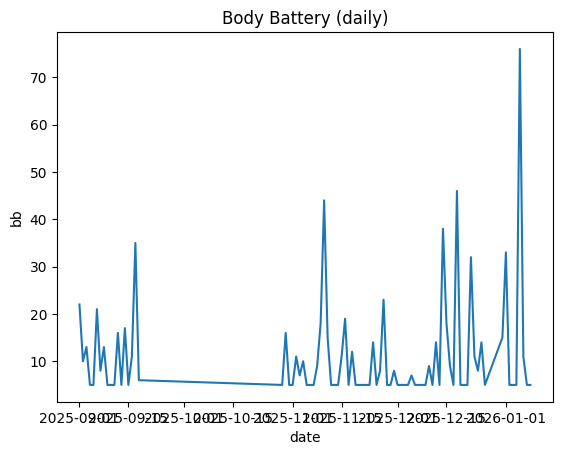

In [13]:
plt.figure()
plt.plot(d["date"], d["bb"])
plt.title("Body Battery (daily)")
plt.xlabel("date")
plt.ylabel("bb")
plt.show()


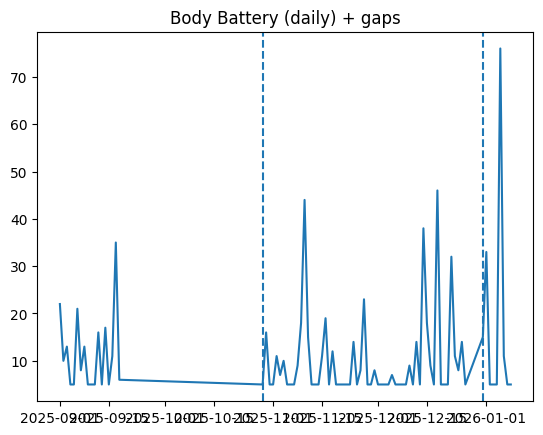

In [14]:
gap = d["date"].diff().dt.days.fillna(1)
gap_idx = d.index[gap > 1]

plt.figure()
plt.plot(d["date"], d["bb"])
for i in gap_idx:
    plt.axvline(d.loc[i, "date"], linestyle="--")
plt.title("Body Battery (daily) + gaps")
plt.show()


In [15]:
q10 = d["bb"].quantile(0.10)
q90 = d["bb"].quantile(0.90)

low = d[d["bb"] <= q10].copy()
high = d[d["bb"] >= q90].copy()

print("q10:", q10, "q90:", q90)
print("low days:", len(low), "high days:", len(high))

display(low[["date","bb","stress","hr","resp","sleep_flag"]].sort_values("bb").head(10))
display(high[["date","bb","stress","hr","resp","sleep_flag"]].sort_values("bb", ascending=False).head(10))


q10: 5.0 q90: 21.5
low days: 45 high days: 9


,date,bb,stress,hr,resp,sleep_flag
3,2025-09-04,5.0,61.120879,76.368280,14.318459,0
4,2025-09-05,5.0,40.962500,67.487923,14.067971,1
8,2025-09-09,5.0,41.285714,67.296900,14.073475,1
9,2025-09-10,5.0,39.881910,67.634831,14.089428,1
10,2025-09-11,5.0,63.014577,80.640278,15.388939,1
12,2025-09-13,5.0,41.355049,66.694600,14.084726,1
14,2025-09-15,5.0,44.702233,68.238364,14.514099,1
18,2025-10-29,5.0,55.660256,76.808362,14.190000,0
20,2025-10-31,5.0,38.471014,67.763889,14.089810,1
21,2025-11-01,5.0,46.425532,71.924419,15.332885,1


,date,bb,stress,hr,resp,sleep_flag
82,2026-01-05,76.0,16.212291,59.188612,13.504593,1
68,2025-12-18,46.0,24.980916,65.630928,13.946902,1
30,2025-11-10,44.0,22.626829,60.638889,13.400612,1
64,2025-12-14,38.0,24.213675,65.164251,14.025815,0
16,2025-09-17,35.0,24.484043,63.804598,12.933542,0
78,2026-01-01,33.0,51.302594,80.750000,14.687939,1
72,2025-12-22,32.0,32.558621,65.765278,14.757139,1
47,2025-11-27,23.0,27.644928,62.783333,14.014504,1
0,2025-09-01,22.0,25.229508,65.481944,14.351736,1


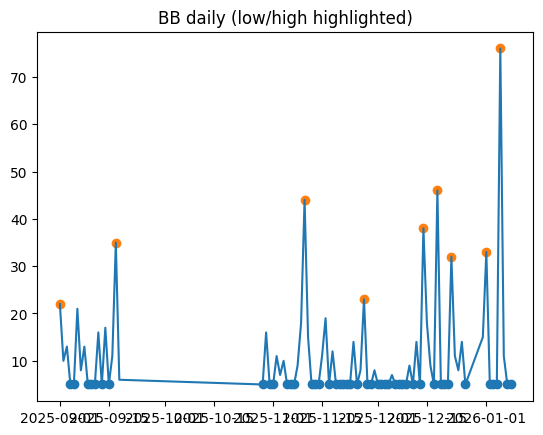

In [16]:
plt.figure()
plt.plot(d["date"], d["bb"])
plt.scatter(low["date"], low["bb"])
plt.scatter(high["date"], high["bb"])
plt.title("BB daily (low/high highlighted)")
plt.show()


In [17]:
cols = ["bb","stress","hr","resp","sleep_flag","steps","kcal"]
corr = d[cols].corr(method="spearman")
corr["bb"].sort_values(ascending=False)


bb            1.000000
steps        -0.107542
sleep_flag   -0.134722
kcal         -0.278574
resp         -0.294827
hr           -0.337064
stress       -0.421652
Name: bb, dtype: float64

In [18]:
dd = d.copy()
for c in ["stress","hr","resp","sleep_flag","steps","kcal","bb"]:
    dd[f"{c}_prev"] = dd[c].shift(1)

# Correlación de BB con variables del día anterior
lag_cols = [f"{c}_prev" for c in ["stress","hr","resp","sleep_flag","steps","kcal","bb"]]
tmp = dd[["bb"] + lag_cols].dropna()

tmp.corr(method="spearman")["bb"].sort_values(ascending=False)


bb                 1.000000
hr_prev            0.158110
resp_prev          0.134736
kcal_prev          0.120749
stress_prev        0.116117
steps_prev         0.112009
bb_prev            0.018794
sleep_flag_prev   -0.074298
Name: bb, dtype: float64

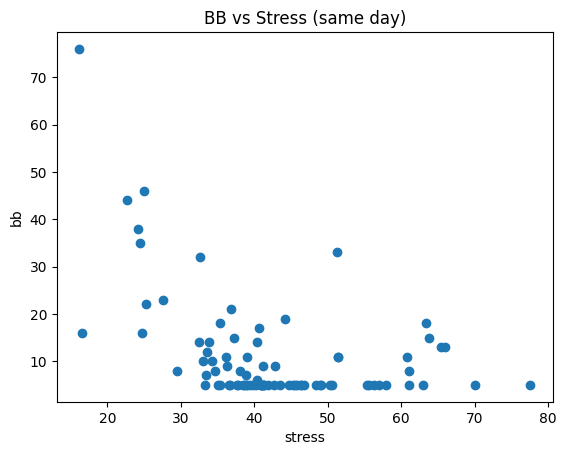

In [19]:
plt.figure()
plt.scatter(d["stress"], d["bb"])
plt.title("BB vs Stress (same day)")
plt.xlabel("stress")
plt.ylabel("bb")
plt.show()


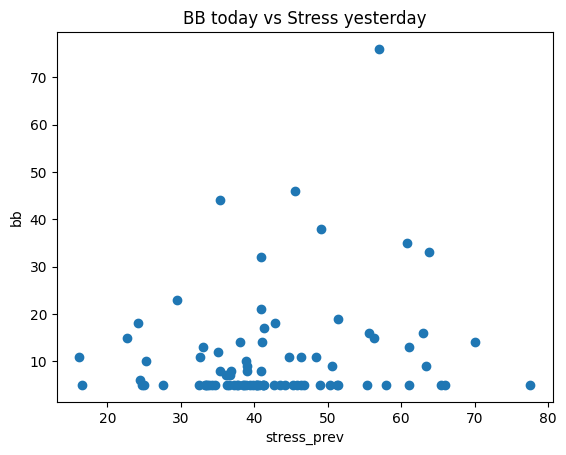

In [20]:
plt.figure()
plt.scatter(dd["stress_prev"], dd["bb"])
plt.title("BB today vs Stress yesterday")
plt.xlabel("stress_prev")
plt.ylabel("bb")
plt.show()


/tmp/ipykernel_35411/2666032553.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby("bin")["bb"].agg(["mean","count"])


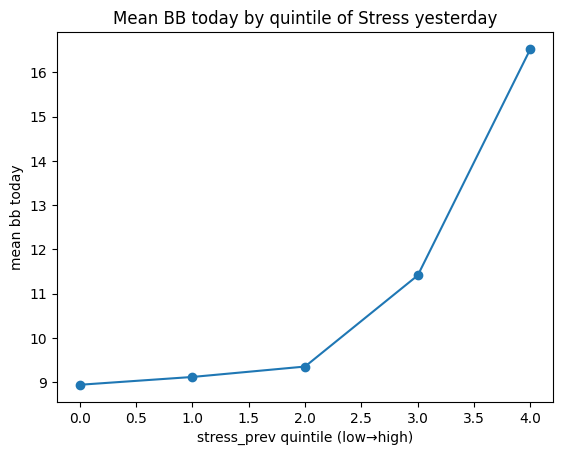

,mean,count
bin,,
"(16.211, 34.173]",8.941176,17
"(34.173, 38.917]",9.117647,17
"(38.917, 41.897]",9.352941,17
"(41.897, 51.315]",11.411765,17
"(51.315, 77.586]",16.529412,17


In [21]:
tmp = dd.dropna(subset=["stress_prev","bb"]).copy()
tmp["bin"] = pd.qcut(tmp["stress_prev"], q=5, duplicates="drop")
grp = tmp.groupby("bin")["bb"].agg(["mean","count"])

plt.figure()
plt.plot(grp["mean"].values, marker="o")
plt.title("Mean BB today by quintile of Stress yesterday")
plt.xlabel("stress_prev quintile (low→high)")
plt.ylabel("mean bb today")
plt.show()

grp


In [22]:
def robust_z(s):
    med = np.nanmedian(s)
    mad = np.nanmedian(np.abs(s - med))
    if mad == 0 or np.isnan(mad):
        return (s - med) * np.nan
    return 0.6745 * (s - med) / mad

d2 = d.copy()
d2["bb_z"] = robust_z(d2["bb"])
anom = d2.sort_values("bb_z").head(10)

display(anom[["date","bb","bb_z","stress","hr","resp","sleep_flag","steps","kcal"]])


,date,bb,bb_z,stress,hr,resp,sleep_flag,steps,kcal
0,2025-09-01,22.0,NaN,25.229508,65.481944,14.351736,1,14615.0,2670.0
1,2025-09-02,10.0,NaN,33.005376,64.300000,13.208244,1,8685.0,2221.0
2,2025-09-03,13.0,NaN,65.975309,76.236994,14.214818,0,2633.0,2219.0
3,2025-09-04,5.0,NaN,61.120879,76.368280,14.318459,0,7898.0,2311.0
4,2025-09-05,5.0,NaN,40.962500,67.487923,14.067971,1,12518.0,2436.0
5,2025-09-06,21.0,NaN,36.865815,67.268631,13.273376,1,14554.0,2573.0
6,2025-09-07,8.0,NaN,61.076923,81.403509,15.429504,0,8237.0,2582.0
7,2025-09-08,13.0,NaN,65.480000,82.490000,15.354839,0,9109.0,2356.0
8,2025-09-09,5.0,NaN,41.285714,67.296900,14.073475,1,7517.0,2371.0
9,2025-09-10,5.0,NaN,39.881910,67.634831,14.089428,1,9663.0,2253.0


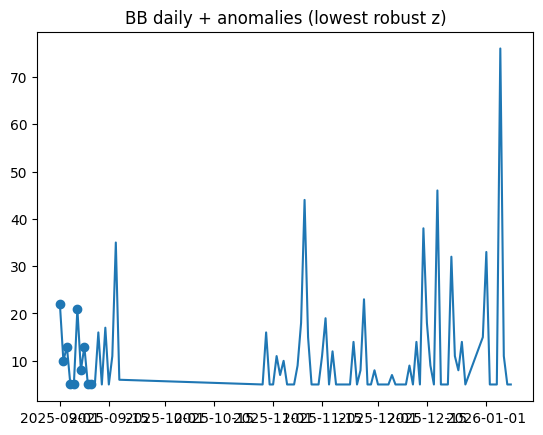

In [23]:
plt.figure()
plt.plot(d2["date"], d2["bb"])
plt.scatter(anom["date"], anom["bb"])
plt.title("BB daily + anomalies (lowest robust z)")
plt.show()


In [24]:
d3 = d2.copy()
for c in ["stress","hr","resp","sleep_flag","steps","kcal","bb"]:
    d3[f"{c}_prev"] = d3[c].shift(1)

cols_show = ["date","bb","bb_z","stress_prev","hr_prev","resp_prev","sleep_flag_prev","steps_prev","kcal_prev"]
display(d3.loc[anom.index, cols_show])


,date,bb,bb_z,stress_prev,hr_prev,resp_prev,sleep_flag_prev,steps_prev,kcal_prev
0,2025-09-01,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-02,10.0,NaN,25.229508,65.481944,14.351736,1.0,14615.0,2670.0
2,2025-09-03,13.0,NaN,33.005376,64.300000,13.208244,1.0,8685.0,2221.0
3,2025-09-04,5.0,NaN,65.975309,76.236994,14.214818,0.0,2633.0,2219.0
4,2025-09-05,5.0,NaN,61.120879,76.368280,14.318459,0.0,7898.0,2311.0
5,2025-09-06,21.0,NaN,40.962500,67.487923,14.067971,1.0,12518.0,2436.0
6,2025-09-07,8.0,NaN,36.865815,67.268631,13.273376,1.0,14554.0,2573.0
7,2025-09-08,13.0,NaN,61.076923,81.403509,15.429504,0.0,8237.0,2582.0
8,2025-09-09,5.0,NaN,65.480000,82.490000,15.354839,0.0,9109.0,2356.0
9,2025-09-10,5.0,NaN,41.285714,67.296900,14.073475,1.0,7517.0,2371.0


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = d[["bb","stress","hr","resp","sleep_flag","steps","kcal"]].copy()
X = X.replace([np.inf,-np.inf], np.nan).dropna()

sc = StandardScaler()
Xn = sc.fit_transform(X)

scores = {}
for k in range(2,6):
    lab = KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(Xn)
    scores[k] = silhouette_score(Xn, lab)
scores


{2: 0.3411417463478772,
 3: 0.4112091380797499,
 4: 0.4142589571485846,
 5: 0.35413187391604306}

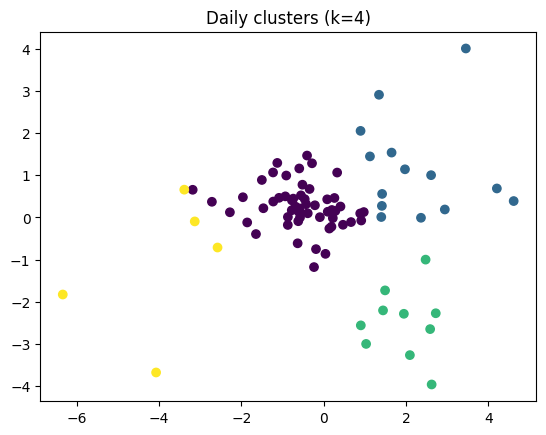

,bb,stress,sleep_flag,steps,kcal
cluster,,,,,
0,5.0,39.07,1.0,8954.0,2371.0
1,5.0,49.86,1.0,19289.5,2906.5
2,9.5,62.25,0.0,8067.5,2333.5
3,44.0,24.21,1.0,11498.0,1708.0


In [26]:
k = max(scores, key=scores.get)
km = KMeans(n_clusters=k, n_init=20, random_state=42)
lab = km.fit_predict(Xn)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xn)

plt.figure()
plt.scatter(Z[:,0], Z[:,1], c=lab)
plt.title(f"Daily clusters (k={k})")
plt.show()

d_cl = d.loc[X.index].copy()
d_cl["cluster"] = lab
d_cl.groupby("cluster")[["bb","stress","sleep_flag","steps","kcal"]].median().round(2)


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# --- cargar minute parquet ---
m = pd.read_parquet("data/processed/minute.parquet").copy()
m["timestamp"] = pd.to_datetime(m["timestamp"])
m = m.sort_values("timestamp").set_index("timestamp")

# timezone consistente
tz = "Europe/Madrid"
if m.index.tz is None:
    m.index = m.index.tz_localize(tz)
else:
    m.index = m.index.tz_convert(tz)

# tipos numéricos
for c in ["hr","stress","resp","bb","sleep_flag","steps","kcal"]:
    if c in m.columns:
        m[c] = pd.to_numeric(m[c], errors="coerce")

m["sleep_flag"] = m["sleep_flag"].fillna(0).astype(int)

# --- resample (no quieres diario; 15min va de lujo para análisis) ---
freq = "15min"
FREQ = pd.Timedelta(freq)

x = m[["bb","stress","hr","resp","sleep_flag"]].resample(freq).mean()
x["sleep"] = x["sleep_flag"] > 0.5

# --- detectar segmentos de sueño ---
seg_id = x["sleep"].ne(x["sleep"].shift()).cumsum()

def first_idx(s): return s.index[0]
def last_idx(s):  return s.index[-1]

seg = (
    x.assign(seg_id=seg_id)
     .groupby(["seg_id","sleep"])
     .agg(
         start=("sleep", first_idx),
         end=("sleep", last_idx),
         n=("sleep", "size"),
         stress_mean=("stress", "mean"),
         hr_mean=("hr", "mean"),
         resp_mean=("resp", "mean"),
         bb_mean=("bb", "mean")
     )
     .reset_index()
)

seg["duration_min"] = seg["n"] * (FREQ.total_seconds()/60)

sleep_segs = seg[seg["sleep"]].sort_values("start").reset_index(drop=True)

print("sleep segments total:", len(sleep_segs))
display(sleep_segs.head(10))


sleep segments total: 70


,seg_id,sleep,start,end,n,stress_mean,hr_mean,resp_mean,bb_mean,duration_min
0,2,True,2025-09-01 09:00:00+02:00,2025-09-01 12:30:00+02:00,15,9.053333,51.779762,12.764810,29.975610,225.0
1,4,True,2025-09-02 03:45:00+02:00,2025-09-02 06:45:00+02:00,13,13.430769,54.160714,13.755037,30.675717,195.0
2,6,True,2025-09-05 06:00:00+02:00,2025-09-05 09:00:00+02:00,13,8.200000,48.813187,13.292321,35.888634,195.0
3,8,True,2025-09-06 09:30:00+02:00,2025-09-06 15:15:00+02:00,24,9.919444,51.069940,12.563028,39.815280,360.0
4,10,True,2025-09-09 04:30:00+02:00,2025-09-09 09:00:00+02:00,19,9.115789,50.713346,12.749962,38.407722,285.0
5,12,True,2025-09-10 02:15:00+02:00,2025-09-10 07:15:00+02:00,21,27.161905,60.480442,14.245876,22.403974,315.0
6,14,True,2025-09-11 10:45:00+02:00,2025-09-11 13:45:00+02:00,13,38.938462,66.417582,14.703297,5.000000,195.0
7,16,True,2025-09-12 01:15:00+02:00,2025-09-12 09:00:00+02:00,32,6.800000,49.532924,13.261032,56.099777,480.0
8,18,True,2025-09-13 04:45:00+02:00,2025-09-13 08:45:00+02:00,17,15.423529,53.412815,14.207983,28.752917,255.0
9,20,True,2025-09-14 07:15:00+02:00,2025-09-14 14:00:00+02:00,28,13.907143,53.404337,13.419037,35.355633,420.0


In [28]:
MIN_SLEEP_MIN = 120  # ajustable: 90 si quieres pillar siestas largas
sleep_events = sleep_segs[sleep_segs["duration_min"] >= MIN_SLEEP_MIN].copy()
sleep_events = sleep_events.sort_values("start").reset_index(drop=True)

def mean_in_window(series, start, end):
    s = series.loc[start:end]
    if s.empty:
        return np.nan
    return float(s.mean())

def pct_above(series, start, end, thr):
    s = series.loc[start:end].dropna()
    if len(s) == 0:
        return np.nan
    return float((s > thr).mean())

rows = []
for _, r in sleep_events.iterrows():
    sleep_start = r["start"]
    sleep_end   = r["end"]
    wake_time   = sleep_end + FREQ  # primera ventana tras el sueño

    if wake_time > x.index.max():
        continue

    # BB justo antes de dormir: último valor válido en la hora previa (más robusto)
    bb_prev = x["bb"].loc[sleep_start - pd.Timedelta("60min"):sleep_start].dropna()
    bb_before_sleep = float(bb_prev.iloc[-1]) if len(bb_prev) else np.nan

    # BB al despertar: media de la primera hora despierto (evita un punto raro)
    bb_w = x["bb"].loc[wake_time:wake_time + pd.Timedelta("60min")].dropna()
    bb_first_awake = float(bb_w.mean()) if len(bb_w) else np.nan

    sleep_hours = r["duration_min"] / 60.0

    # ventanas temporales (lo que Garmin no te resume bien)
    pre3   = (sleep_start - pd.Timedelta("3h"), sleep_start - FREQ)
    pre6   = (sleep_start - pd.Timedelta("6h"), sleep_start - FREQ)
    during = (sleep_start, sleep_end)

    stress_pre3_mean = mean_in_window(x["stress"], *pre3)
    stress_pre3_hi   = pct_above(x["stress"], *pre3, thr=50)

    stress_sleep_mean = mean_in_window(x["stress"], *during)
    stress_sleep_hi   = pct_above(x["stress"], *during, thr=50)

    hr_pre3_mean    = mean_in_window(x["hr"], *pre3)
    hr_sleep_mean   = mean_in_window(x["hr"], *during)
    resp_sleep_mean = mean_in_window(x["resp"], *during)

    bb_recharge = (bb_first_awake - bb_before_sleep
                   if np.isfinite(bb_first_awake) and np.isfinite(bb_before_sleep)
                   else np.nan)

    bb_recharge_per_h = (bb_recharge / sleep_hours
                         if np.isfinite(bb_recharge) and sleep_hours > 0
                         else np.nan)

    rows.append({
        "sleep_start": sleep_start,
        "sleep_end": sleep_end,
        "wake_time": wake_time,
        "sleep_hours": sleep_hours,

        "bb_before_sleep": bb_before_sleep,
        "bb_first_awake": bb_first_awake,
        "bb_recharge": bb_recharge,
        "bb_recharge_per_h": bb_recharge_per_h,

        "stress_pre3_mean": stress_pre3_mean,
        "stress_pre3_hi_pct": stress_pre3_hi,
        "stress_sleep_mean": stress_sleep_mean,
        "stress_sleep_hi_pct": stress_sleep_hi,

        "hr_pre3_mean": hr_pre3_mean,
        "hr_sleep_mean": hr_sleep_mean,
        "resp_sleep_mean": resp_sleep_mean,

        "wake_hour": wake_time.hour + wake_time.minute/60.0,
        "sleep_start_hour": sleep_start.hour + sleep_start.minute/60.0,
        "weekday": wake_time.day_name(),
    })

cycles = pd.DataFrame(rows)
cycles = cycles.dropna(subset=["bb_first_awake"]).reset_index(drop=True)

print("cycles:", len(cycles))
display(cycles.head(10))


cycles: 68


,sleep_start,sleep_end,wake_time,sleep_hours,bb_before_sleep,bb_first_awake,bb_recharge,bb_recharge_per_h,stress_pre3_mean,stress_pre3_hi_pct,stress_sleep_mean,stress_sleep_hi_pct,hr_pre3_mean,hr_sleep_mean,resp_sleep_mean,wake_hour,sleep_start_hour,weekday
0,2025-09-01 09:00:00+02:00,2025-09-01 12:30:00+02:00,2025-09-01 12:45:00+02:00,3.75,17.170732,48.268293,31.097561,8.292683,24.770833,0.000000,9.053333,0.000000,62.444940,51.779762,12.764810,12.75,9.00,Monday
1,2025-09-02 03:45:00+02:00,2025-09-02 06:45:00+02:00,2025-09-02 07:00:00+02:00,3.25,16.271605,42.358117,26.086512,8.026619,57.116667,0.750000,13.430769,0.000000,73.556548,54.160714,13.755037,7.00,3.75,Tuesday
2,2025-09-05 06:00:00+02:00,2025-09-05 09:00:00+02:00,2025-09-05 09:15:00+02:00,3.25,27.312369,55.430970,28.118601,8.651877,60.975000,1.000000,8.200000,0.000000,76.242857,48.813187,13.292321,9.25,6.00,Friday
3,2025-09-06 09:30:00+02:00,2025-09-06 15:15:00+02:00,2025-09-06 15:30:00+02:00,6.00,17.537415,59.203663,41.666248,6.944375,39.854545,0.272727,9.919444,0.000000,70.684524,51.069940,12.563028,15.50,9.50,Saturday
4,2025-09-09 04:30:00+02:00,2025-09-09 09:00:00+02:00,2025-09-09 09:15:00+02:00,4.75,19.462783,62.429106,42.966323,9.045542,55.520833,0.666667,9.115789,0.000000,71.413690,50.713346,12.749962,9.25,4.50,Tuesday
5,2025-09-10 02:15:00+02:00,2025-09-10 07:15:00+02:00,2025-09-10 07:30:00+02:00,5.25,13.463576,30.941644,17.478068,3.329156,66.361111,1.000000,27.161905,0.047619,77.154762,60.480442,14.245876,7.50,2.25,Wednesday
6,2025-09-11 10:45:00+02:00,2025-09-11 13:45:00+02:00,2025-09-11 14:00:00+02:00,3.25,5.000000,5.000000,0.000000,0.000000,86.700000,1.000000,38.938462,0.307692,91.212798,66.417582,14.703297,14.00,10.75,Thursday
7,2025-09-12 01:15:00+02:00,2025-09-12 09:00:00+02:00,2025-09-12 09:15:00+02:00,8.00,18.408805,88.204444,69.795639,8.724455,37.158333,0.333333,6.800000,0.000000,69.092262,49.532924,13.261032,9.25,1.25,Friday
8,2025-09-13 04:45:00+02:00,2025-09-13 08:45:00+02:00,2025-09-13 09:00:00+02:00,4.25,15.526316,43.460317,27.934002,6.572706,57.706944,0.833333,15.423529,0.000000,72.363095,53.412815,14.207983,9.00,4.75,Saturday
9,2025-09-14 07:15:00+02:00,2025-09-14 14:00:00+02:00,2025-09-14 14:15:00+02:00,7.00,5.617886,67.317073,61.699187,8.814170,68.270833,1.000000,13.907143,0.000000,75.790179,53.404337,13.419037,14.25,7.25,Sunday


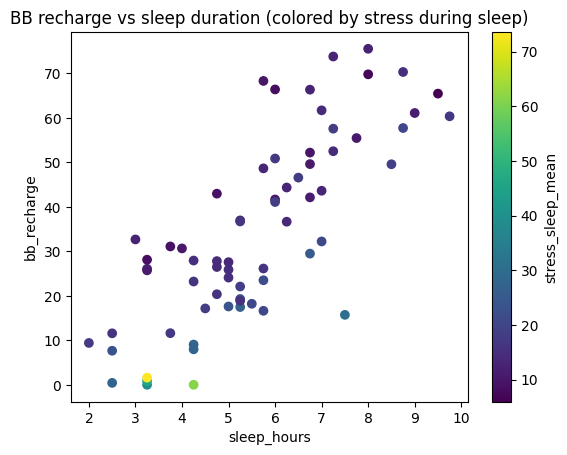

In [29]:
plt.figure()
plt.scatter(cycles["sleep_hours"], cycles["bb_recharge"], c=cycles["stress_sleep_mean"])
plt.colorbar(label="stress_sleep_mean")
plt.title("BB recharge vs sleep duration (colored by stress during sleep)")
plt.xlabel("sleep_hours")
plt.ylabel("bb_recharge")
plt.show()


/tmp/ipykernel_35411/2167438871.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby("bin")["bb_recharge_per_h"].agg(["mean","count","std"])


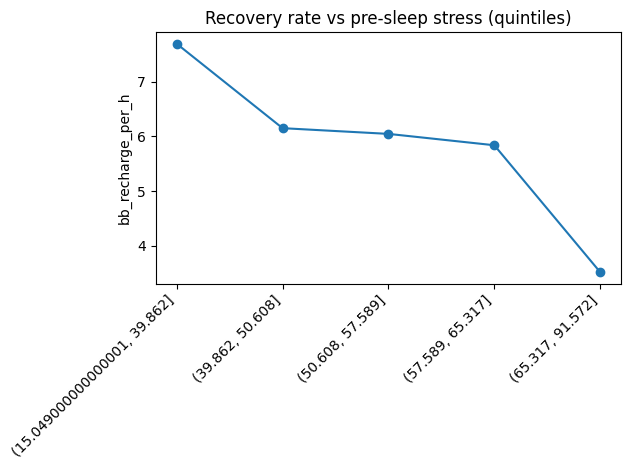

,mean,count,std,se
bin,,,,
"(15.049000000000001, 39.862]",7.689414,14,1.488290,0.397762
"(39.862, 50.608]",6.147708,13,2.305773,0.639506
"(50.608, 57.589]",6.043134,14,2.332969,0.623512
"(57.589, 65.317]",5.835813,13,2.505556,0.694916
"(65.317, 91.572]",3.517808,14,3.384357,0.904507


In [30]:
tmp = cycles.dropna(subset=["stress_pre3_mean","bb_recharge_per_h"]).copy()
tmp["bin"] = pd.qcut(tmp["stress_pre3_mean"], q=5, duplicates="drop")
grp = tmp.groupby("bin")["bb_recharge_per_h"].agg(["mean","count","std"])
grp["se"] = grp["std"] / np.sqrt(grp["count"])

plt.figure()
plt.plot(range(len(grp)), grp["mean"].values, marker="o")
plt.xticks(range(len(grp)), [str(b) for b in grp.index], rotation=45, ha="right")
plt.title("Recovery rate vs pre-sleep stress (quintiles)")
plt.ylabel("bb_recharge_per_h")
plt.tight_layout()
plt.show()

display(grp)


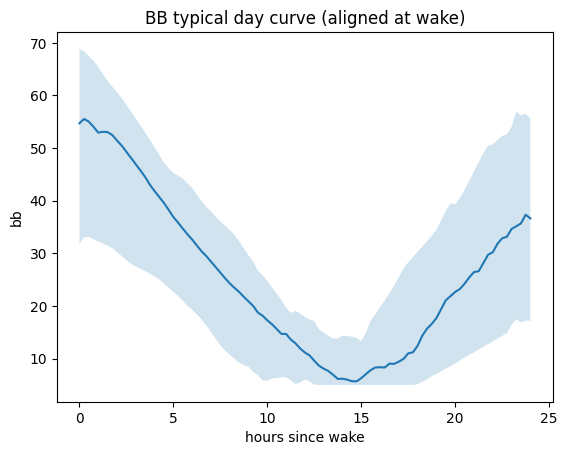

In [31]:
def aligned_curves(series, anchors, hours=24, freq="15min"):
    out = []
    for t0 in anchors:
        w = series.loc[t0:t0 + pd.Timedelta(hours, "h")].resample(freq).mean()
        if len(w) < 10:
            continue
        w.index = (w.index - t0).total_seconds()/3600  # horas desde wake
        out.append(w.rename(t0))
    if not out:
        return None
    return pd.concat(out, axis=1)

bb_curves = aligned_curves(x["bb"], cycles["wake_time"], hours=24, freq=freq)
med = bb_curves.median(axis=1)
p25 = bb_curves.quantile(0.25, axis=1)
p75 = bb_curves.quantile(0.75, axis=1)

plt.figure()
plt.plot(med.index, med.values)
plt.fill_between(med.index, p25.values, p75.values, alpha=0.2)
plt.title("BB typical day curve (aligned at wake)")
plt.xlabel("hours since wake")
plt.ylabel("bb")
plt.show()


In [32]:
worst = cycles.sort_values("bb_first_awake").head(10).copy()
display(worst[[
    "wake_time","bb_first_awake","bb_recharge_per_h","sleep_hours",
    "stress_pre3_mean","stress_sleep_mean","hr_sleep_mean"
]])


,wake_time,bb_first_awake,bb_recharge_per_h,sleep_hours,stress_pre3_mean,stress_sleep_mean,hr_sleep_mean
6,2025-09-11 14:00:00+02:00,5.000000,0.000000,3.25,86.700000,38.938462,66.417582
63,2026-01-04 11:15:00+01:00,5.000000,0.000000,4.25,84.812121,61.376471,79.183824
52,2025-12-13 10:45:00+01:00,5.866044,0.266475,3.25,86.027273,46.184615,68.107143
14,2025-11-01 14:00:00+01:00,5.980967,0.171522,2.50,67.609722,27.420000,60.448214
61,2025-12-26 10:15:00+01:00,6.658120,0.495864,3.25,91.571667,73.584615,75.802198
25,2025-11-12 13:30:00+01:00,16.255556,1.876601,4.25,50.237500,27.588235,61.363445
47,2025-12-08 10:30:00+01:00,17.053728,4.628899,2.50,48.440278,16.220000,59.387500
40,2025-11-29 05:30:00+01:00,17.395062,2.127732,4.25,77.578788,27.384314,59.519958
36,2025-11-25 05:30:00+01:00,17.897436,3.062171,2.50,75.237500,23.280000,60.237500
55,2025-12-20 12:15:00+01:00,20.722222,2.096296,7.50,64.590000,30.240000,67.947024


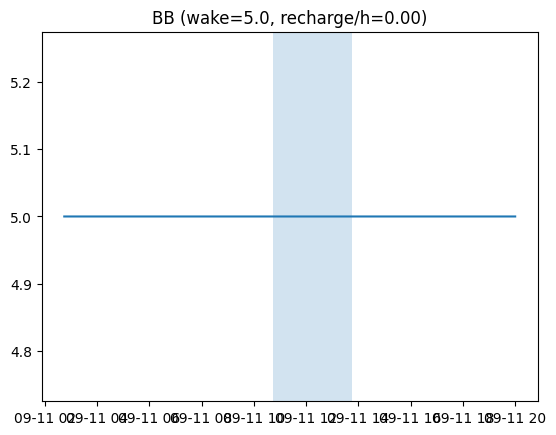

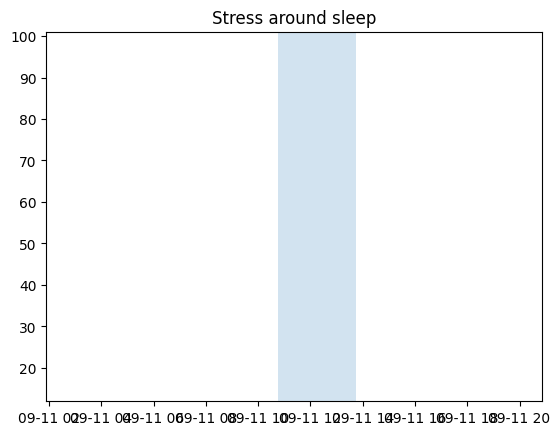

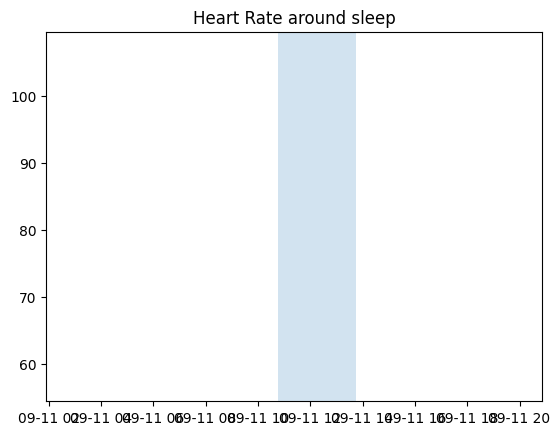

In [33]:
def plot_case(row, hours_before=8, hours_after=6):
    t0 = row["sleep_start"] - pd.Timedelta(hours_before, "h")
    t1 = row["wake_time"] + pd.Timedelta(hours_after, "h")
    w = m.loc[t0:t1, ["bb","stress","hr","resp","sleep_flag"]].copy()
    if w.empty:
        print("empty window")
        return

    plt.figure()
    plt.plot(w.index, w["bb"])
    plt.axvspan(row["sleep_start"], row["sleep_end"], alpha=0.2)
    plt.title(f"BB (wake={row['bb_first_awake']:.1f}, recharge/h={row['bb_recharge_per_h']:.2f})")
    plt.show()

    plt.figure()
    plt.plot(w.index, w["stress"])
    plt.axvspan(row["sleep_start"], row["sleep_end"], alpha=0.2)
    plt.title("Stress around sleep")
    plt.show()

    plt.figure()
    plt.plot(w.index, w["hr"])
    plt.axvspan(row["sleep_start"], row["sleep_end"], alpha=0.2)
    plt.title("Heart Rate around sleep")
    plt.show()

plot_case(worst.iloc[0])
